In [165]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.special import logsumexp

In [166]:
## R-like linear regression designed to work with Pandas
import statsmodels.formula.api as smf

In [167]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")

%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Aug 12 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

matplotlib : 3.5.2
numpy      : 1.22.4
statsmodels: 0.13.2
seaborn    : 0.11.2
pandas     : 1.4.3
pymc       : 4.1.3
sys        : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
arviz      : 0.12.1
scipy      : 1.8.1

Watermark: 2.3.1



In [21]:
def z(X):
    return ( (X - np.mean(X)) / np.std(X) ) 

def standardize_cols(dframe, colnames):
    for x in colnames:
        dframe[x + "_raw"] = dframe[x]
        dframe[x] = z(dframe[x])

In [22]:
brains = pd.DataFrame.from_dict(
    {"species": ["afarensis","africanus","habilis","boisei","rudolfensis","ergaster","sapiens"],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]})  # mass in kg

standardize_cols(brains, ["brain", "mass"])
brains

,species,brain,mass,brain_raw,mass_raw
0,afarensis,-0.924151,-0.841920,438,37.0
1,africanus,-0.877225,-0.990494,452,35.5
2,habilis,-0.340930,-1.089544,612,34.5
3,boisei,-0.645948,-0.396198,521,41.5
4,rudolfensis,0.128328,0.990494,752,55.5
5,ergaster,0.527197,1.535266,871,61.0
6,sapiens,2.132729,0.792396,1350,53.5


In [23]:
m71 = smf.ols("brain ~ mass", data=brains).fit()

In [24]:
print(m71.params, m71.conf_int(), m71.rsquared, sep="\n")

Intercept    9.410941e-17
mass         7.001129e-01
dtype: float64
                  0         1
Intercept -0.820851  0.820851
mass      -0.120738  1.520964
0.490158047949084


In [25]:
m71.resid

0   -0.334712
1   -0.183767
2    0.421873
3   -0.368565
4   -0.565130
5   -0.547663
6    1.577963
dtype: float64

In [26]:
1 - m71.resid.var() / brains["brain"].var()

0.49015804794908413

In [27]:
## I()
m72 = smf.ols("brain ~ mass + I(mass**2)", data=brains).fit()
m75 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) ", data=brains).fit()

In [28]:
m71.summary()

/Users/sasha/miniforge3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  brain   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Fri, 12 Aug 2022   Prob (F-statistic):             0.0798
Time:                        04:48:06   Log-Likelihood:                -7.5748
No. Observations:                   7   AIC:                             19.15
Df Residuals:                       5   BIC:                             19.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.411e-17      0.319   2.95e-16      1.000      -0.821       0.821
mass           0.7001      0.319      2.192      0.080      -0.121       1.521
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
m72.summary()

/Users/sasha/miniforge3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  brain   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     2.310
Date:                Fri, 12 Aug 2022   Prob (F-statistic):              0.215
Time:                        04:48:07   Log-Likelihood:                -7.2450
No. Observations:                   7   AIC:                             20.49
Df Residuals:                       4   BIC:                             20.33
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3870      0.704      0.550      0.612      -1.566       2.340
mass             0.8197      0.390      2.101      0.104      -0.263       1.903
I(mass ** 2)    -0.3870      0.616     -0.629      0.564      -2.096       1.322
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.479
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.016
Skew:                           0.901   Prob(JB):                        0.602
Kurtosis:                       2.514   Cond. No.                         4.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
m75.summary()

/Users/sasha/miniforge3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  brain   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     17.74
Date:                Fri, 12 Aug 2022   Prob (F-statistic):              0.178
Time:                        04:48:07   Log-Likelihood:                 5.8058
No. Observations:                   7   AIC:                            0.3884
Df Residuals:                       1   BIC:                           0.06387
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.0069      0.510      3.933      0.159      -4.477       8.491
mass             7.0766      1.070      6.616      0.096      -6.515      20.668
I(mass ** 2)    -2.6883      1.214     -2.214      0.270     -18.118      12.741
I(mass ** 3)   -10.0404      1.938     -5.182      0.121     -34.659      14.578
I(mass ** 4)     0.3859      0.792      0.488      0.711      -9.673      10.444
I(mass ** 5)     3.3039      0.835      3.956      0.158      -7.308      13.916
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.120
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.659
Skew:                          -0.750   Prob(JB):                        0.719
Kurtosis:                       3.092   Cond. No.                         96.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
m72.predict(brains["mass"])

0   -0.577475
1   -0.804631
2   -0.965561
3    0.001478
4    0.819276
5    0.733340
6    0.793573
dtype: float64

In [32]:
pred = m72.get_prediction(brains["mass"])
pred.predicted_mean

array([-0.57747504, -0.8046311 , -0.96556064,  0.00147778,  0.81927616,
        0.73334026,  0.79357259])

In [33]:
pred.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-0.577475,0.445632,-1.814748,0.659798,-3.368588,2.213638
1,-0.804631,0.510964,-2.223294,0.614032,-3.680752,2.071490
2,-0.965561,0.598115,-2.626194,0.695072,-3.968421,2.037299
3,0.001478,0.575326,-1.595884,1.598840,-2.966860,2.969816
4,0.819276,0.519488,-0.623053,2.261605,-2.068591,3.707144
5,0.733340,0.827394,-1.563875,3.030555,-2.663226,4.129907
6,0.793573,0.577196,-0.808979,2.396124,-2.177562,3.764707


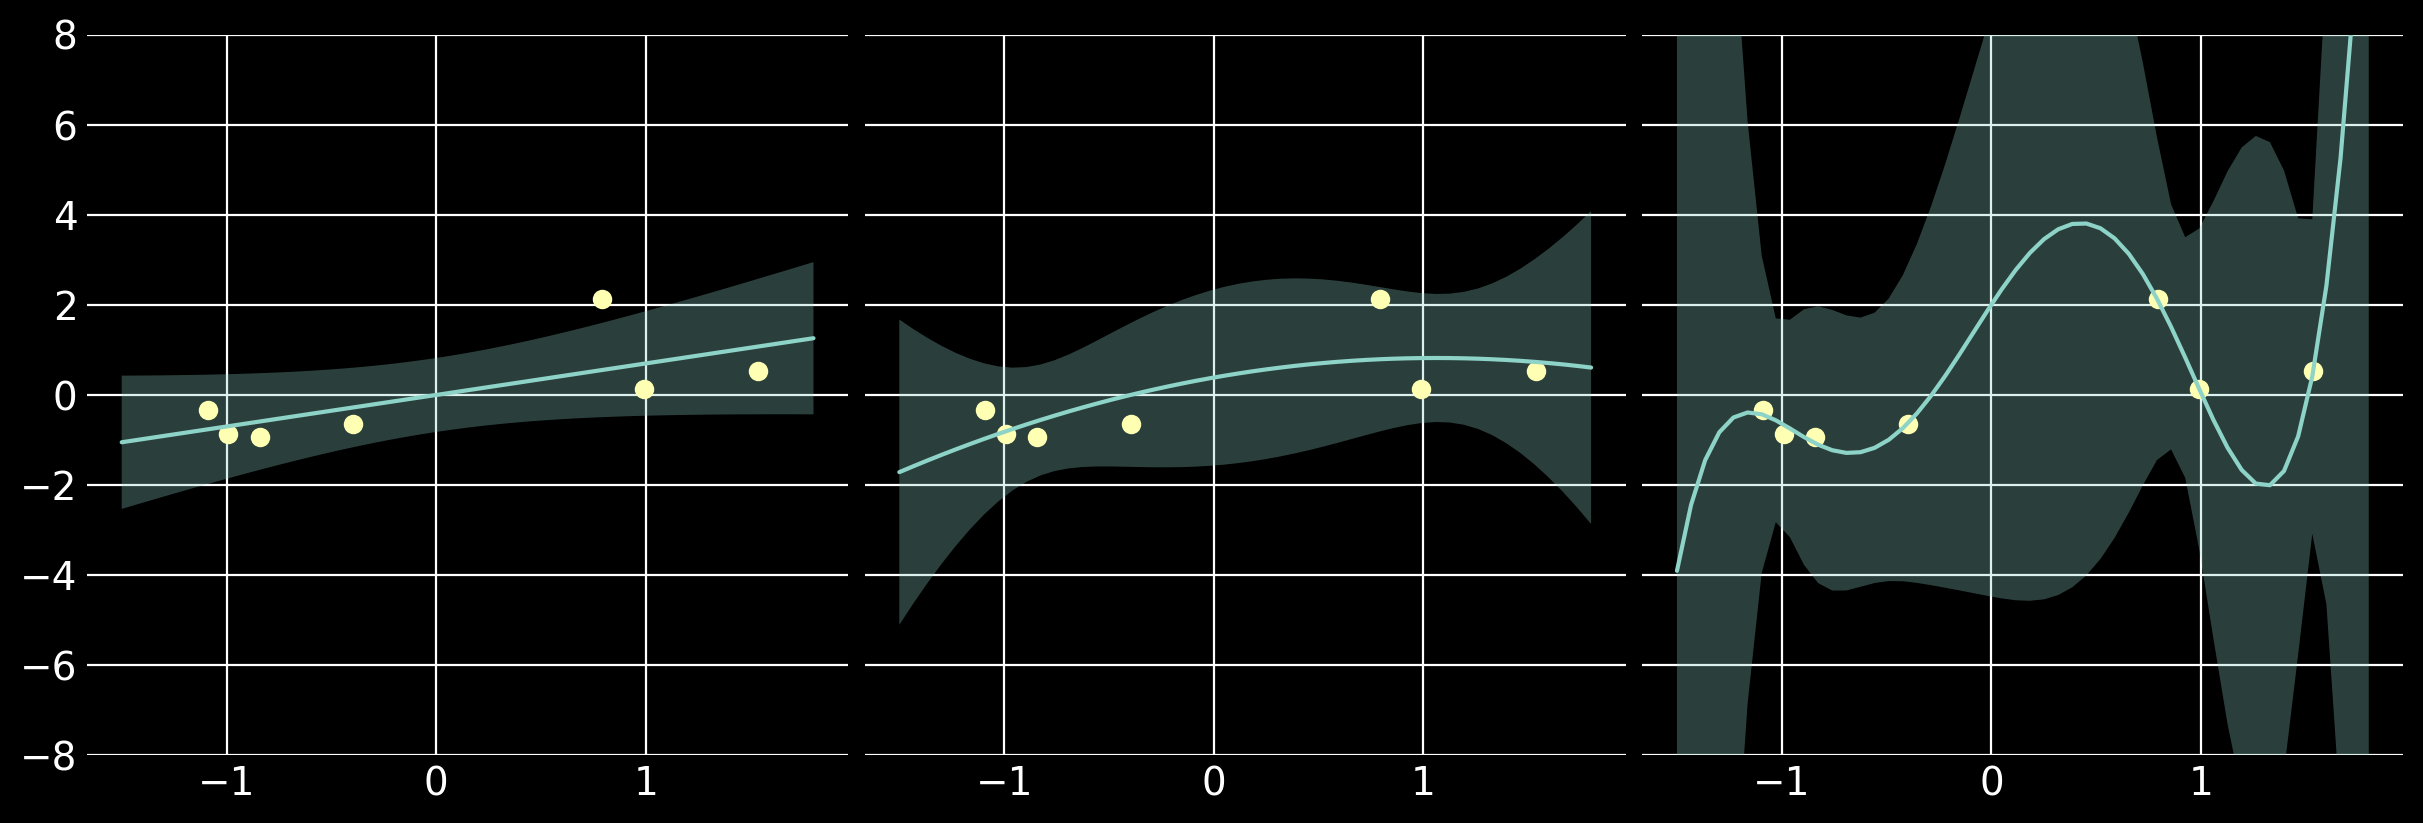

In [116]:
models = [m71, m72, m75]
x = np.linspace(-1.5, 1.8, 50)
_, axs = plt.subplots(1, 3, figsize=[12, 4], sharey=True)

for m, ax in zip(models, axs.flat):
    ## get_prediction() expects something like a data series
    pred = m.get_prediction({"mass": x}).summary_frame()
    ax.plot(x, pred["mean"])
    ## fill_between()
    ax.fill_between(x, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    ax.scatter(brains["mass"], brains["brain"])
    ax.set_ylim(-8, 8)

dropping one data point at a time

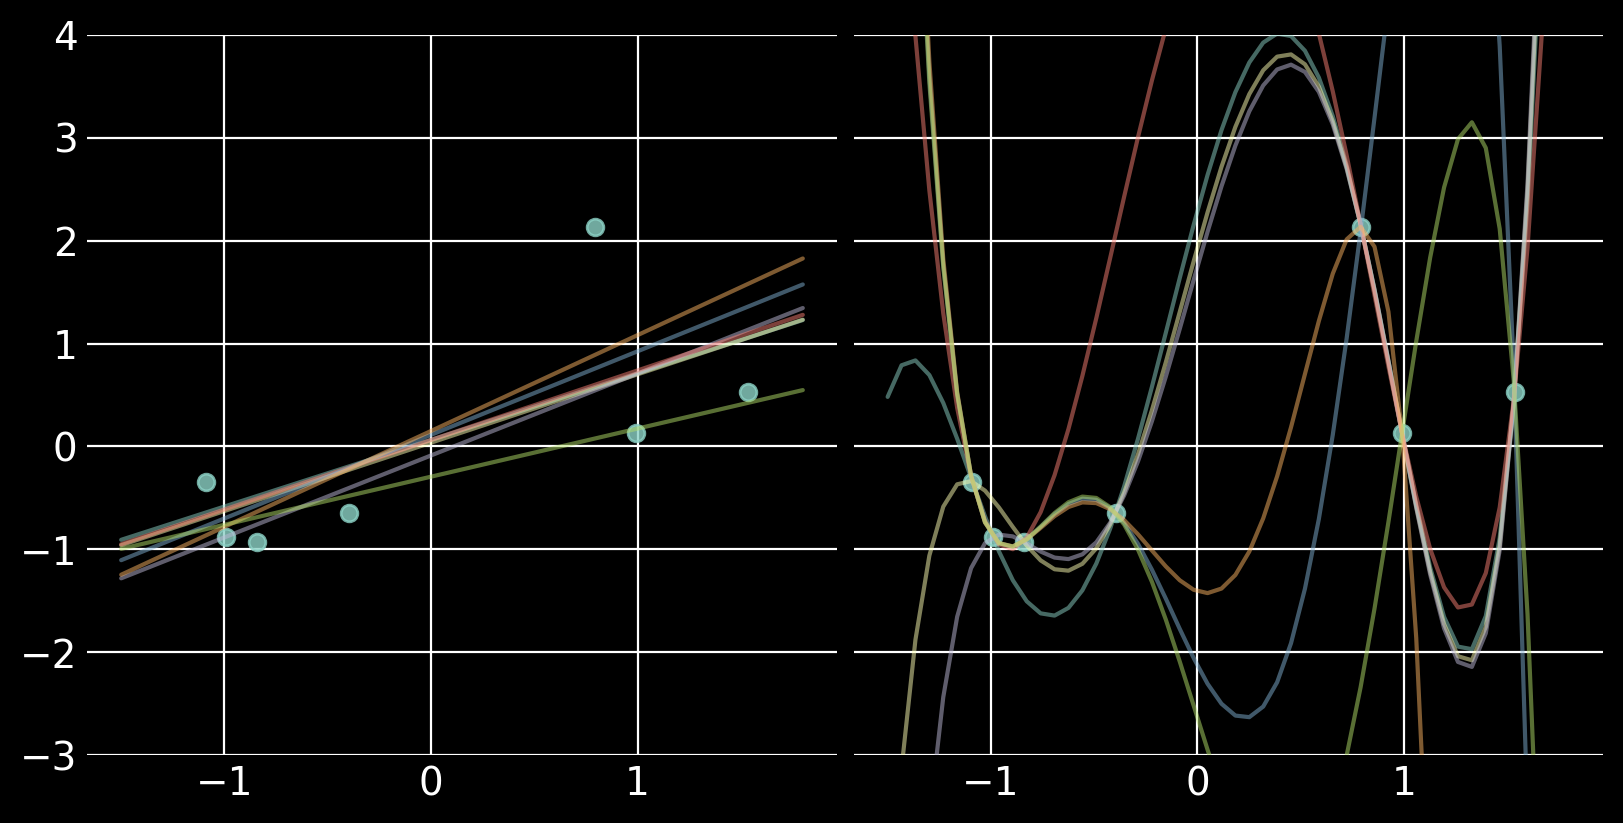

In [113]:
x = np.linspace(-1.5, 1.8, 50)
_, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0].scatter(brains.mass, brains.brain, alpha=0.8)
ax[1].scatter(brains.mass, brains.brain, alpha=0.8)

for i in brains.index:
    d = brains.drop(i)
    m0 = smf.ols("brain ~ mass", data=d).fit()
    ax[0].plot(x, m0.predict({"mass": x}), alpha=0.5)
    ax[0].set_ylim(-3, 4)
    m1 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)", data=d).fit()
    ax[1].plot(x, m1.predict({"mass": x}), alpha=0.5)
    ax[1].set_ylim(-3, 4)

calculating WAIC by hand

In [36]:
data = pd.read_csv("Data/cars.csv", sep=",", index_col=0)
data.head()

,speed,dist
1,4,2
2,4,10
3,7,4
4,7,22
5,8,16


In [37]:
with pm.Model() as m719:
    a = pm.Normal("a", 0, 100)
    b = pm.Normal("b", 0, 10)
    mu = pm.Deterministic("mu", a + b * data["speed"])
    s = pm.Exponential("s", 1)
    dist = pm.Normal("dist", mu, s, observed=data["dist"])
    t719 = pm.sample(tune=2000)

az.summary(t719, var_names=["~mu"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, s]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8826, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-17.547,6.361,-29.375,-5.194,0.174,0.128,1357.0,1309.0,1.0
b,3.930,0.392,3.183,4.639,0.011,0.008,1314.0,1288.0,1.0
s,13.847,1.268,11.619,16.327,0.030,0.021,1791.0,1492.0,1.0


In [38]:
## sample parameter values and get the log-probability of each observation at each sampled value
##  (the posterior distribution of the log-prob of each observation)
n_samples = 1000

logprob = np.array([stats.norm.logpdf(data["dist"], 
                    loc=t719.posterior["mu"][0,i].values, 
                    scale=float(t719.posterior["s"][0,i]))
                for i in range(n_samples)])

np.shape(logprob)

(1000, 50)

In [39]:
## the same information is already in the trace
logprob = t719.log_likelihood["dist"][0,0:1000].values

In [40]:
lppd = np.apply_along_axis(logsumexp, 0, logprob)
lppd -= np.log(n_samples)
np.shape(lppd)

(50,)

In [41]:
pWAIC = np.apply_along_axis(np.var, 0, logprob)
np.shape(pWAIC)

(50,)

In [42]:
## WAIC
-2 * (sum(lppd) - sum(pWAIC))

422.33716573555785

In [43]:
## built in to arviz
az.waic(t719, scale="deviance")

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   421.77    16.28
p_waic            4.29        -

There has been a warning during the calculation. Please check the results.

arviz provides model comparison

In [44]:
with pm.Model() as m719b:
    a = pm.Normal("a", 0, 100)
    mu = pm.Deterministic("mu", a)
    s = pm.Exponential("s", 1)
    dist = pm.Normal("dist", mu, s, observed=data["dist"])
    t719b = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, s]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.


In [45]:
compare_test = az.compare({"m719": t719, "m719b": t719b}, ic="waic", scale="deviance", method="BB-pseudo-BMA")
compare_test

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m719,0,421.772894,4.293571,0.000000,0.999174,16.773008,0.000000,True,deviance
m719b,1,473.640939,2.812909,51.868045,0.000826,16.417895,13.919347,True,deviance


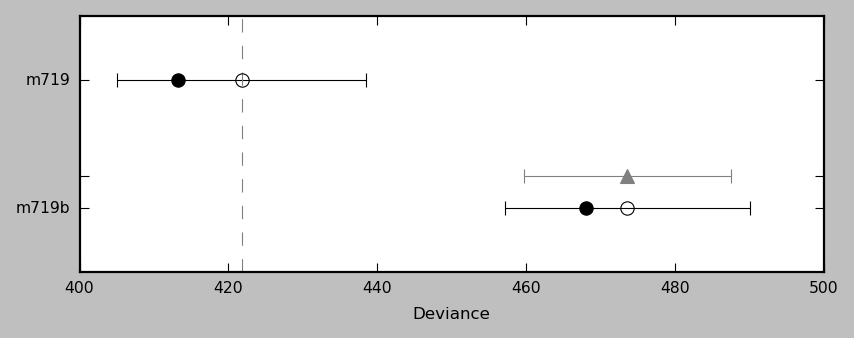

In [112]:
with plt.style.context(style="classic", after_reset=True):
    az.plot_compare(compare_test);

7.5.2 outliers

In [117]:
d = pd.read_csv("Data/WaffleDivorce.csv", delimiter=";")
d["A"] = stats.zscore(d["MedianAgeMarriage"])
d["D"] = stats.zscore(d["Divorce"])
d["M"] = stats.zscore(d["Marriage"])
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D,M
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.612445,1.671000,0.022874
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.693671,1.560044,1.565536
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.206314,0.616916,0.049472
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.424706,2.114824,1.671927
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.605947,-0.936470,-0.269700


In [118]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    mu = a + bA * d["A"]
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d["D"])
    m_5_1_trace = pm.sample(progressbar=False);

with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    mu = a + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d["D"])
    m_5_2_trace = pm.sample(progressbar=False);

with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d["D"])
    m_5_3_trace = pm.sample(progressbar=False);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [120]:
## PSIS comparison
az.compare({"m_5_1": m_5_1_trace, "m_5_2": m_5_2_trace, "m_5_3": m_5_3_trace},
    scale="deviance", method="BB-pseudo-BMA")

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_5_1,0,127.028870,3.763091,0.000000,0.651221,12.466142,0.000000,True,deviance
m_5_3,1,128.877329,4.876214,1.848459,0.264475,9.640879,0.713652,True,deviance
m_5_2,2,140.423485,2.997757,13.394614,0.084303,12.510243,9.356509,False,deviance


/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


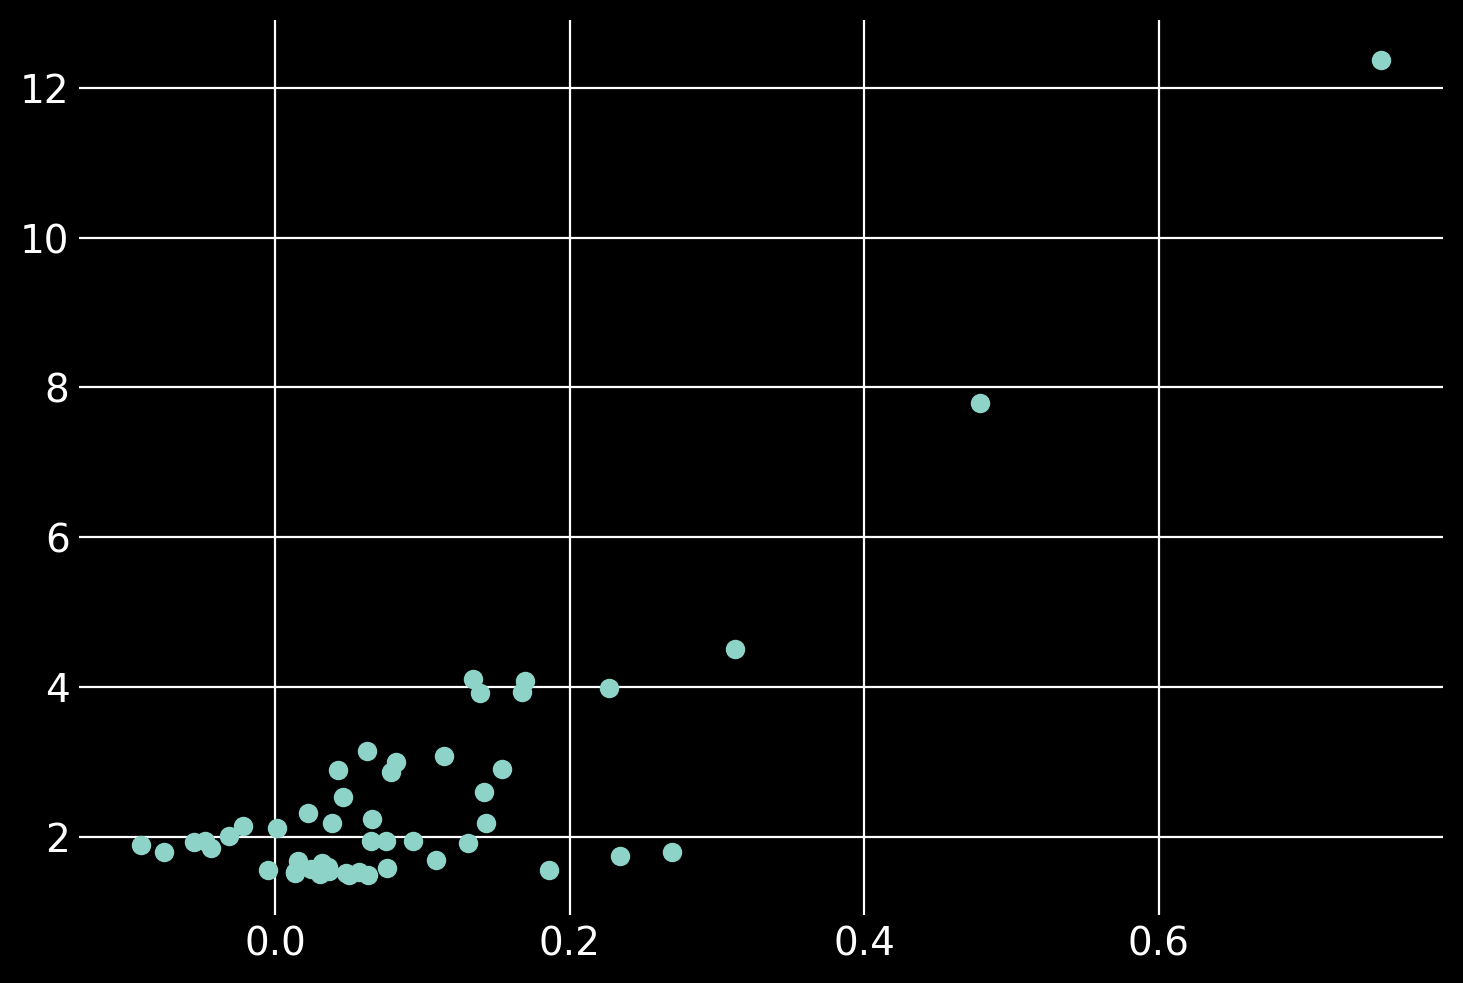

In [131]:
psis_m_5_3 = az.loo(m_5_3_trace, pointwise=True, scale="deviance");
waic_m_5_3 = az.waic(m_5_3_trace, pointwise=True, scale="deviance");

# pareto k values and waic penalty values for individual data points
plt.scatter(psis_m_5_3.pareto_k, waic_m_5_3.waic_i);

In [160]:
## robust regression using t distrib

with pm.Model() as m_5_3t:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)
    nu = pm.Exponential("nu", 0.1)
    D = pm.StudentT("D", nu=nu, mu=mu, sigma=sigma, observed=d["D"])
    #D = pm.StudentT("D", nu=2, mu=mu, sigma=sigma, observed=d["D"])
    m_5_3t_trace = pm.sample(progressbar=False);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma, nu]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [161]:
az.summary(m_5_3t_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.011,0.099,-0.176,0.195,0.002,0.001,3579.0,2810.0,1.0
bA,-0.654,0.156,-0.934,-0.359,0.003,0.002,2997.0,3021.0,1.0
bM,-0.033,0.166,-0.333,0.289,0.003,0.002,3002.0,2715.0,1.0
sigma,0.739,0.098,0.555,0.927,0.002,0.001,2968.0,2573.0,1.0
nu,12.717,9.841,1.857,31.097,0.174,0.123,2927.0,3243.0,1.0


In [162]:
az.loo(m_5_3t_trace, pointwise=True, scale="deviance")

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

             Estimate       SE
deviance_loo   127.94    12.03
p_loo            4.79        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       49   98.0%
 (0.5, 0.7]   (ok)          1    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


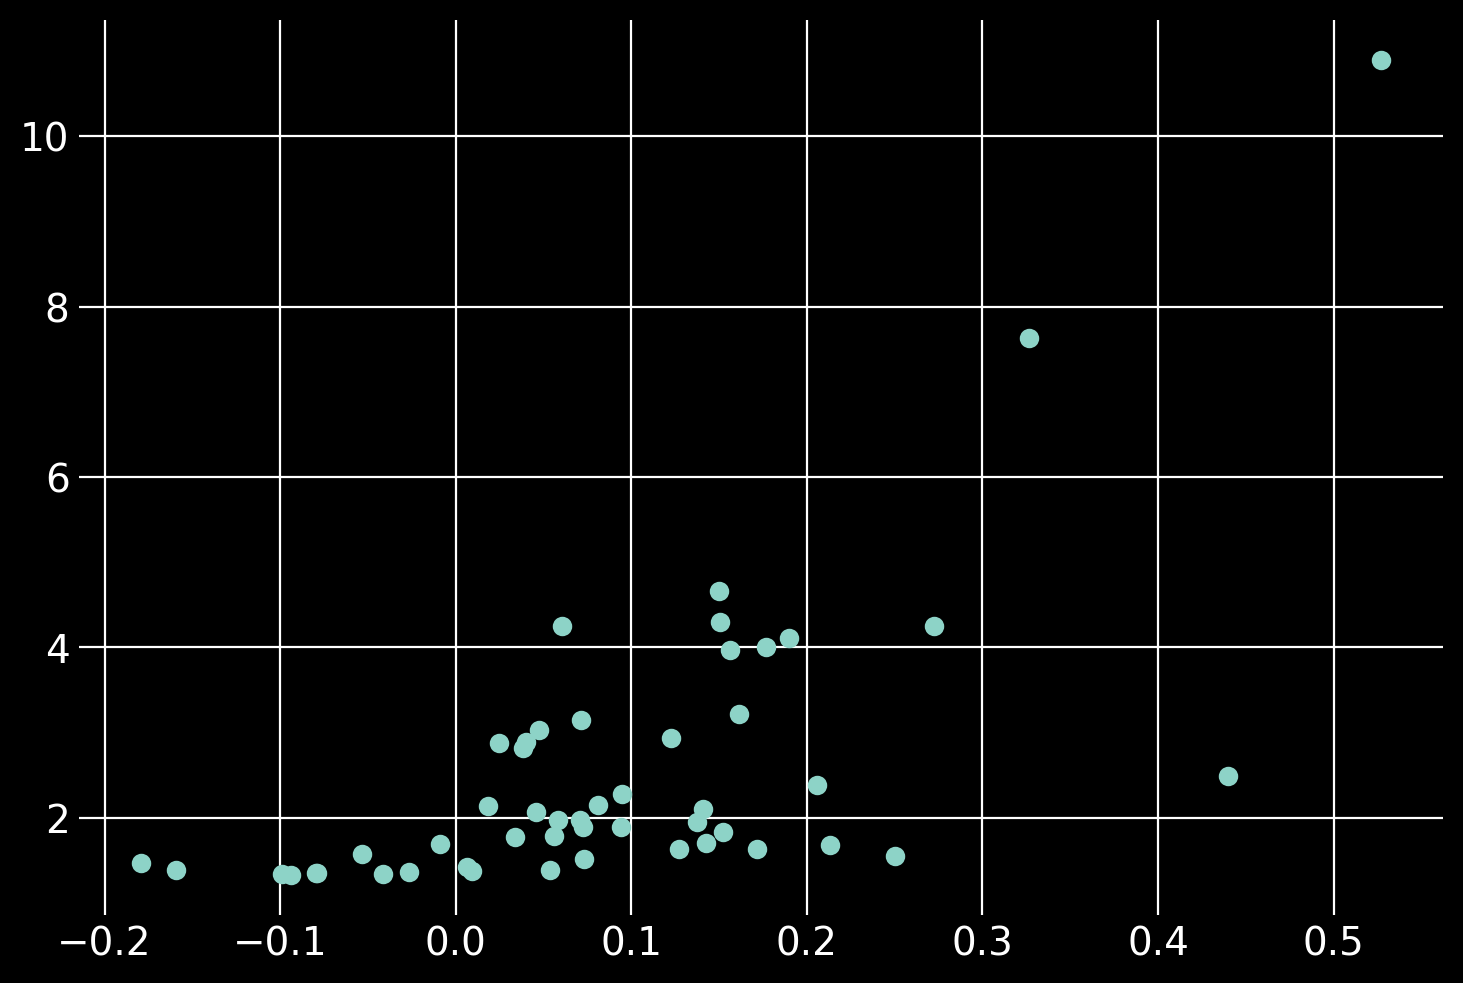

In [163]:
psis_m_5_3t = az.loo(m_5_3t_trace, pointwise=True, scale="deviance");
waic_m_5_3t = az.waic(m_5_3t_trace, pointwise=True, scale="deviance");

# pareto k values and waic penalty values for individual data points
plt.scatter(psis_m_5_3t.pareto_k, waic_m_5_3t.waic_i);

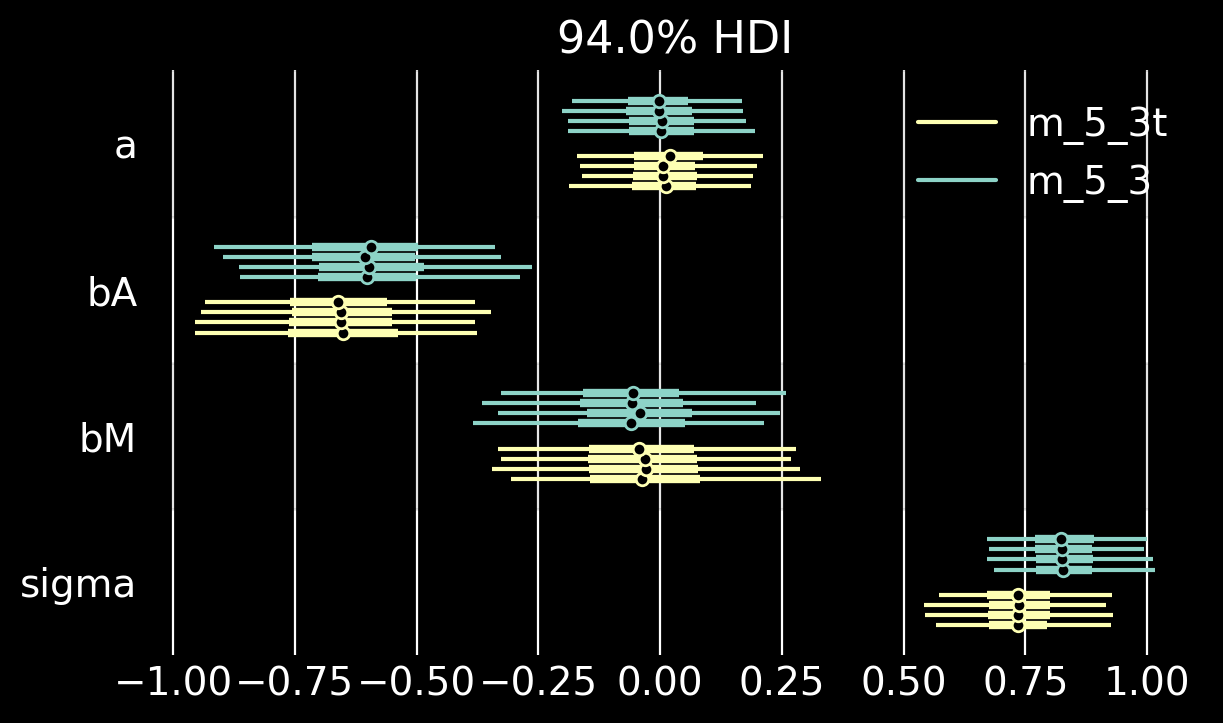

In [164]:
az.plot_forest([m_5_3_trace, m_5_3t_trace], model_names=["m_5_3", "m_5_3t"], figsize=[6, 3.5], var_names=["~nu"]);

ch 8 interaction models

In [185]:
d_ = pd.read_csv("Data/rugged.csv", sep=";")

In [186]:
## put gdp on log scale
d_["log_gdp"] = np.log(d_["rgdppc_2000"])
d = d_.dropna(subset=["log_gdp"]).copy()

# scale log-gdp as a multiple of the mean (1 = mean log-gdp)
# scale rugged as a proportion of the max
d["G"] = d["log_gdp"] / d["log_gdp"].mean()
d["R"] = d["rugged"] / d["rugged"].max()


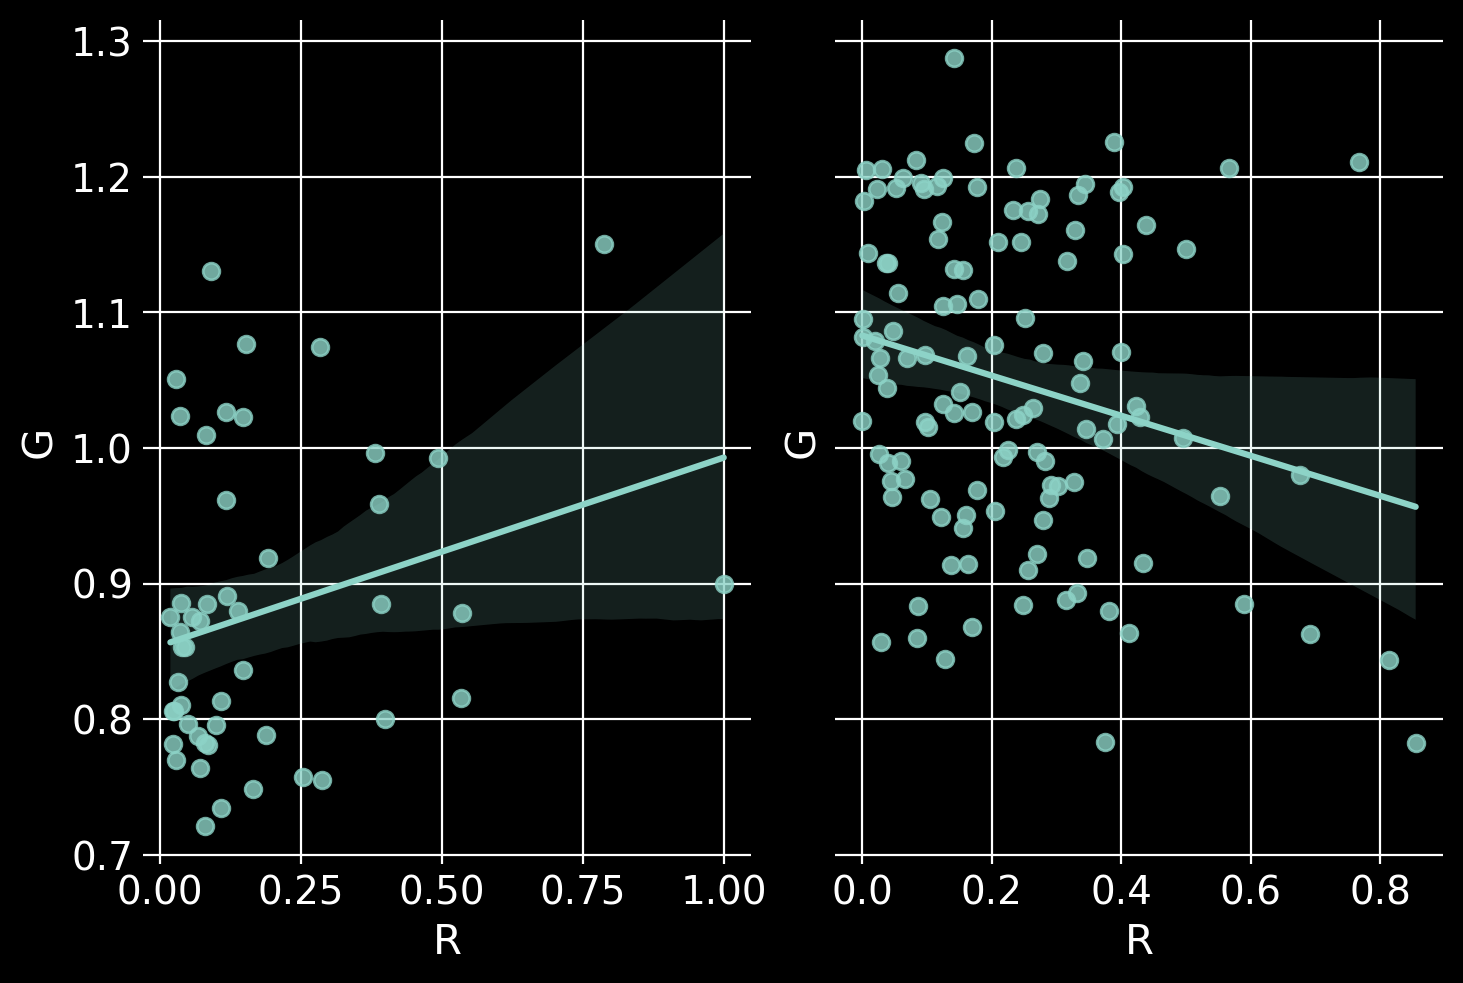

In [184]:
dafrica = d["cont_africa"] == 1
_, ax = plt.subplots(1, 2, sharey=True)
sns.regplot(x=d[dafrica]["R"], y=d[dafrica]["G"], ax=ax[0])
sns.regplot(x=d[~dafrica]["R"], y=d[~dafrica]["G"], ax=ax[1]);

In [264]:
d[["G","R"]].describe()

,G,R
count,170.000000,170.000000
mean,1.000000,0.214960
std,0.136959,0.188402
min,0.721556,0.000484
25%,0.885214,0.071308
50%,1.007176,0.157933
75%,1.113081,0.315584
max,1.287361,1.000000


In [297]:
with pm.Model() as m81:
    #scaled log-gdp should be around 1 when R = R_mean
    a = pm.Normal("a", 1, 1)
    b = pm.Normal("b", 0, 1)
    mu = pm.Deterministic("mu", a + b*(d["R"] - d["R"].mean()))
    s = pm.Exponential("s", 1)
    G = pm.Normal("G", mu, s, observed=d["G"])
    prior81 = pm.sample_prior_predictive()

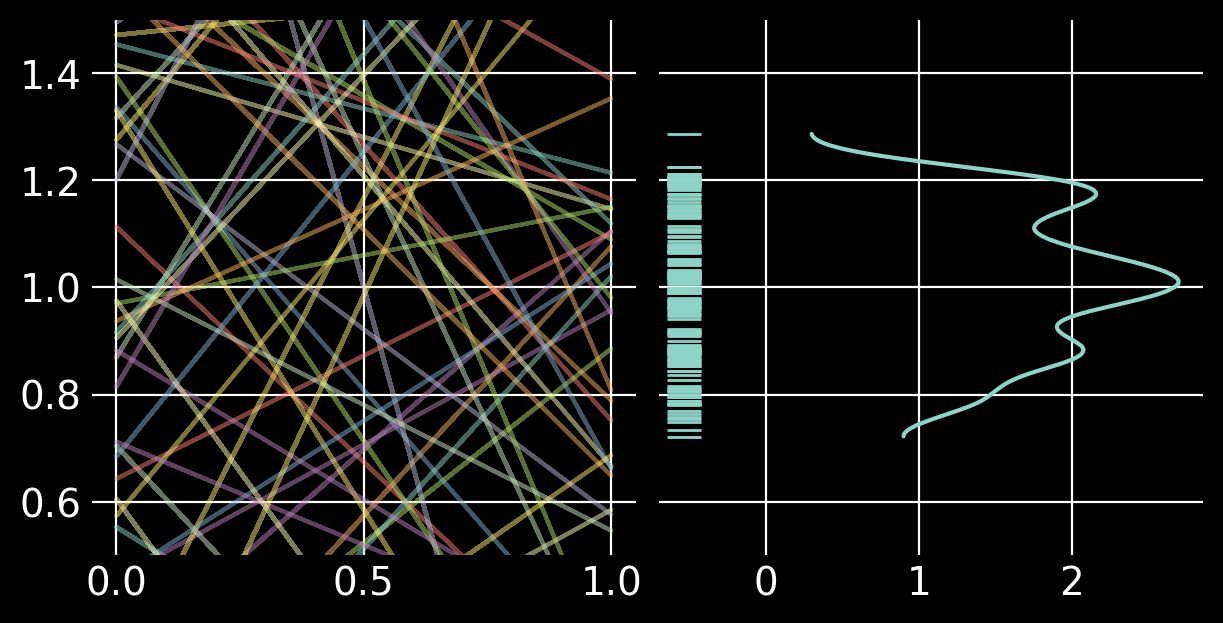

In [298]:
## prior predictive
_, ax = plt.subplots(1, 2, figsize=[6,3], sharey=True)
ax[0].set_ylim(0.5,1.5)
ax[0].plot(d["R"], prior81.prior["mu"][0][0:100].T, alpha=0.5);
#az.plot_violin(d["G"].values,ax=ax[1])
az.plot_dist(d["G"].values,rotated=True,rug=True,ax=ax[1]);


In [303]:
with pm.Model() as m81:
    # G ~~ 1 +/- 0.3
    a = pm.Normal("a", 1, 0.15)
    # (max G - min G) / (max R - min R) ~~ 0.6
    b = pm.Normal("b", 0, 0.3)
    mu = pm.Deterministic("mu", a + b*(d["R"] - d["R"].mean()))
    s = pm.Exponential("s", 1)
    G = pm.Normal("G", mu, s, observed=d["G"])
    prior81 = pm.sample_prior_predictive()

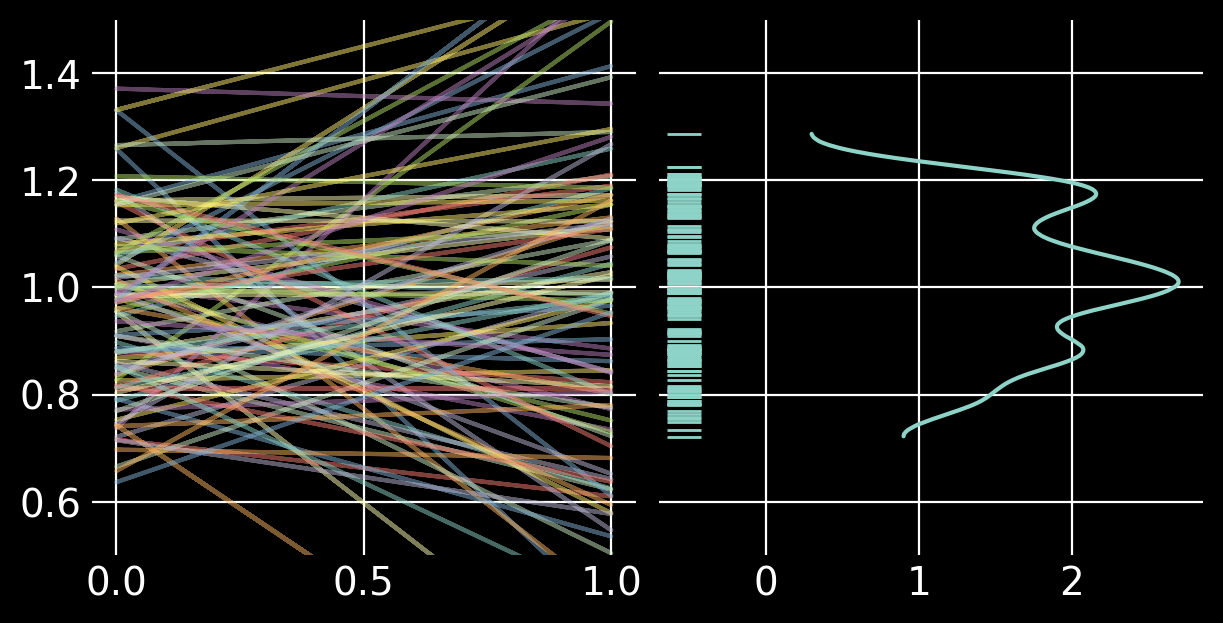

In [304]:
## prior predictive
_, ax = plt.subplots(1, 2, figsize=[6,3], sharey=True)
ax[0].set_ylim(0.5,1.5)
ax[0].plot(d["R"], prior81.prior["mu"][0][0:100].T, alpha=0.5);
#az.plot_violin(d["G"].values,ax=ax[1])
az.plot_dist(d["G"].values,rotated=True,rug=True,ax=ax[1]);

In [402]:
## additive continent effect: separate intercepts, but same slope

with pm.Model() as m82:
    a = pm.Normal("a", 1, 0.15, shape=2)
    b = pm.Normal("b", 0, 0.3)
    mu = pm.Deterministic("mu", a[d["cont_africa"]] + b*(d["R"] - d["R"].mean()))
    s = pm.Exponential("s", 1)
    G = pm.Normal("G", mu, s, observed=d["G"])    


In [403]:
## interaction between continent and ruggedness

with pm.Model() as m83:
    a = pm.Normal("a", 1, 0.15, shape=2)
    b = pm.Normal("b", 0, 0.3, shape=2)
    mu = pm.Deterministic("mu", a[d["cont_africa"]] + b[d["cont_africa"]] * (d["R"] - d["R"].mean()))
    s = pm.Exponential("s", 1)
    G = pm.Normal("G", mu, s, observed=d["G"])    

In [404]:
trace81 = pm.sample(model=m81, progressbar=False)
trace82 = pm.sample(model=m82, progressbar=False)
trace83 = pm.sample(model=m83, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, s]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, s]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, s]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [409]:
az.summary(trace83, var_names=["~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.051,0.010,1.031,1.069,0.000,0.000,6094.0,3484.0,1.0
a[1],0.885,0.016,0.856,0.916,0.000,0.000,7783.0,3166.0,1.0
b[0],-0.143,0.056,-0.245,-0.035,0.001,0.001,6383.0,3482.0,1.0
b[1],0.131,0.076,-0.013,0.271,0.001,0.001,5284.0,3344.0,1.0
s,0.111,0.006,0.100,0.123,0.000,0.000,5059.0,3173.0,1.0


In [410]:
az.compare({"m81": trace81, "m82": trace82, "m83": trace83}, scale="deviance", method="BB-pseudo-BMA")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m83,0,-259.072335,5.083739,0.000000,8.157262e-01,13.416925,0.000000,False,deviance
m82,1,-252.527272,4.031265,6.545063,1.842738e-01,14.751387,6.450176,False,deviance
m81,2,-188.731363,2.632357,70.340972,4.780619e-09,14.319923,15.107020,False,deviance


8.3 continuous interactions

In [415]:
d = pd.read_csv("Data/tulips.csv", sep=';')
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


In [418]:
d.describe()

,water,shade,blooms
count,27.00000,27.00000,27.000000
mean,2.00000,2.00000,128.993704
std,0.83205,0.83205,92.683923
min,1.00000,1.00000,0.000000
25%,1.00000,1.00000,71.115000
50%,2.00000,2.00000,111.040000
75%,3.00000,3.00000,190.300000
max,3.00000,3.00000,361.660000


In [421]:
## keep 0 blooms at 0
d["B"] = d["blooms"] / d["blooms"].max()
## water and shade will go from -1 to +1
d["W"] = d["water"] - d["water"].mean()
d["S"] = d["shade"] - d["shade"].mean()

In [424]:
## no interaction
with pm.Model() as m84:
    ## intercept = proportion blooms at mean water and shade
    ## should be centered at 0.5 and not go below 0
    a = pm.Normal("a", 0.5, 0.25)
    ## blooms range from 0 to 1, predictors range from -1 to 1
    ## slope should be less than 0.5
    bW = pm.Normal("bW", 0, 0.25)
    bS = pm.Normal("bS", 0, 0.25)
    mu = pm.Deterministic("mu", a + bW*d["W"] + bS*d["S"])
    s = pm.Exponential("s", 1)
    B = pm.Normal("B", mu, s, observed=d["B"])
    prior84 = pm.sample_prior_predictive()
    trace84 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bW, bS, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [426]:
## shade * water
with pm.Model() as m85:
    ## intercept = proportion blooms at mean water and shade
    ## should be centered at 0.5 and not go below 0
    a = pm.Normal("a", 0.5, 0.25)
    ## blooms range from 0 to 1, predictors range from -1 to 1
    ## slope should be less than 0.5
    bW = pm.Normal("bW", 0, 0.25)
    bS = pm.Normal("bS", 0, 0.25)
    ## for shade to negate water, bW + bWS*S = 0
    ## max shade is 1, so bWS = -bW
    bWS = pm.Normal("bWS", 0, 0.25)
    mu = pm.Deterministic("mu", a + bW*d["W"] + bS*d["S"] + bWS*d["W"]*d["S"])
    s = pm.Exponential("s", 1)
    B = pm.Normal("B", mu, s, observed=d["B"])
    prior85 = pm.sample_prior_predictive()
    trace85 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bW, bS, bWS, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


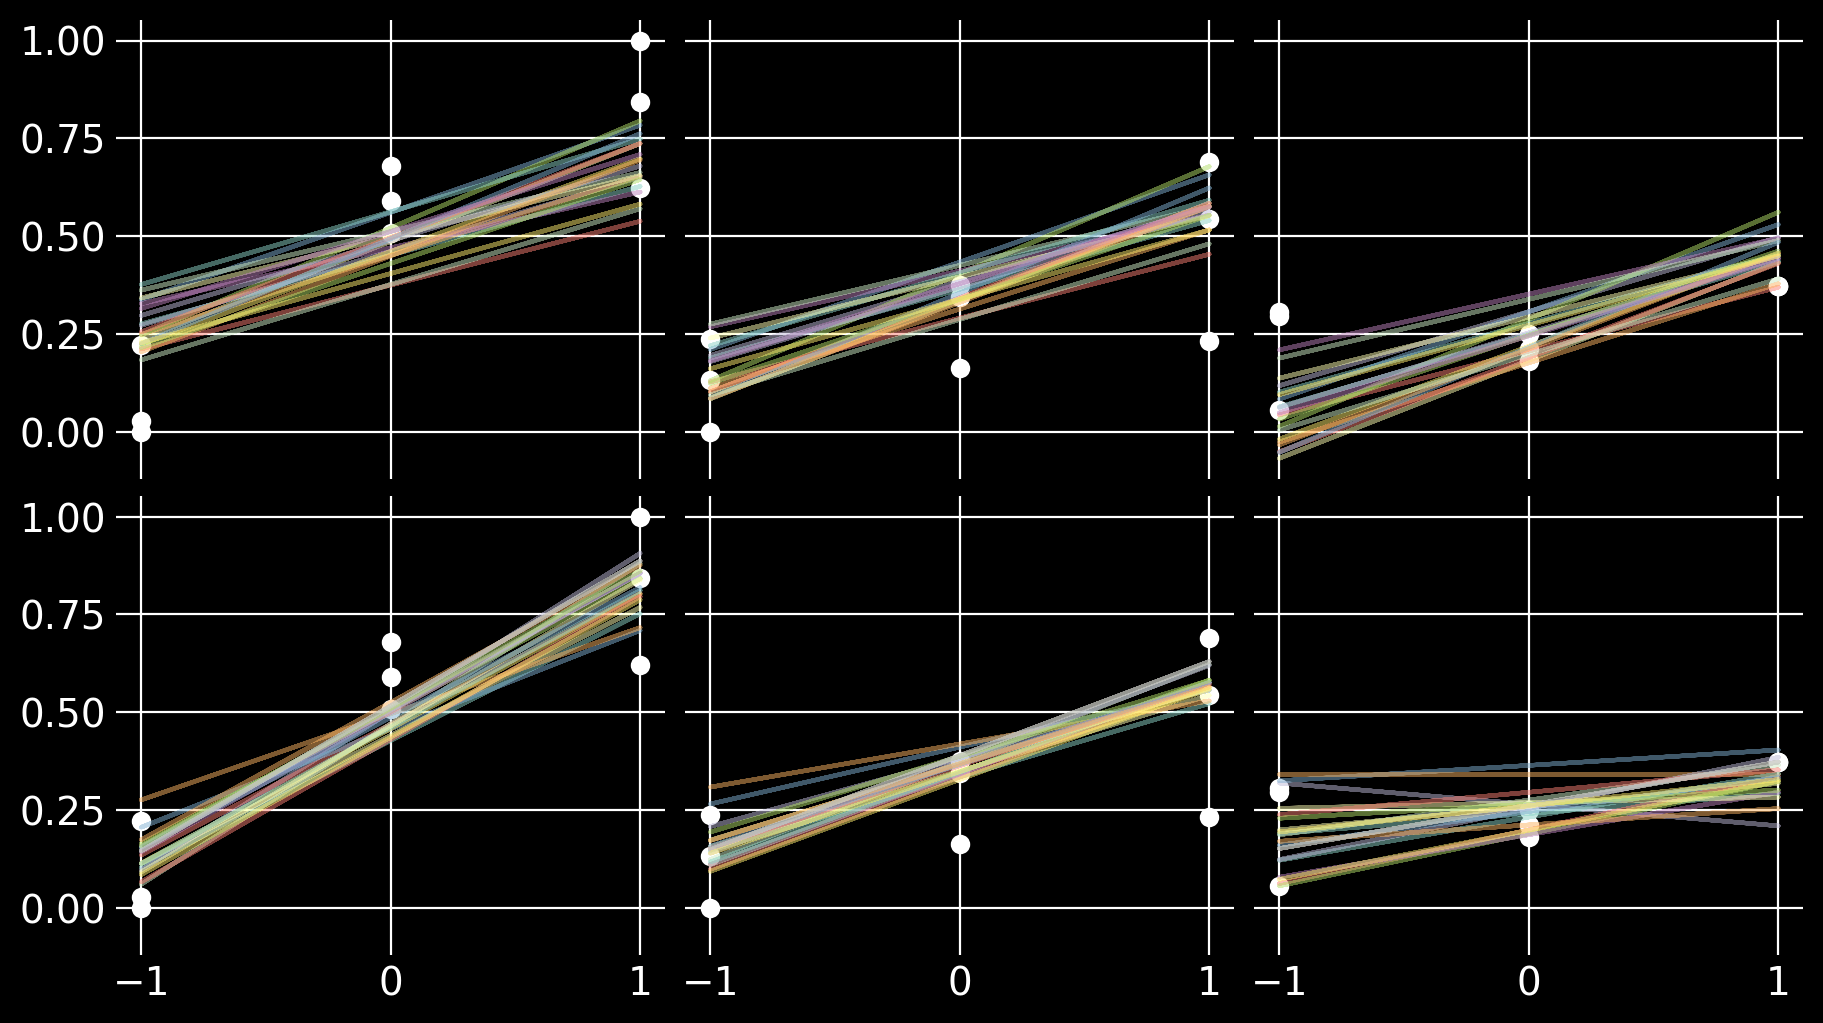

In [451]:
## posterior regression lines
## top row: m84, same bW for all shades
## bottom: m85, bW depends on shade

_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)
n = 20

for i, shade in enumerate([-1, 0, 1]):
    idx = d["S"] == shade
    ax = axs[0, i]
    ax.scatter(d[idx]["W"], d[idx]["B"], color="w")
    ax.plot(d[idx]["W"], trace84.posterior["mu"][0,0:n,idx].T, alpha=0.5);

    ax = axs[1, i]
    ax.scatter(d[idx]["W"], d[idx]["B"], color="w")
    ax.plot(d[idx]["W"], trace85.posterior["mu"][0,0:n,idx].T, alpha=0.5);


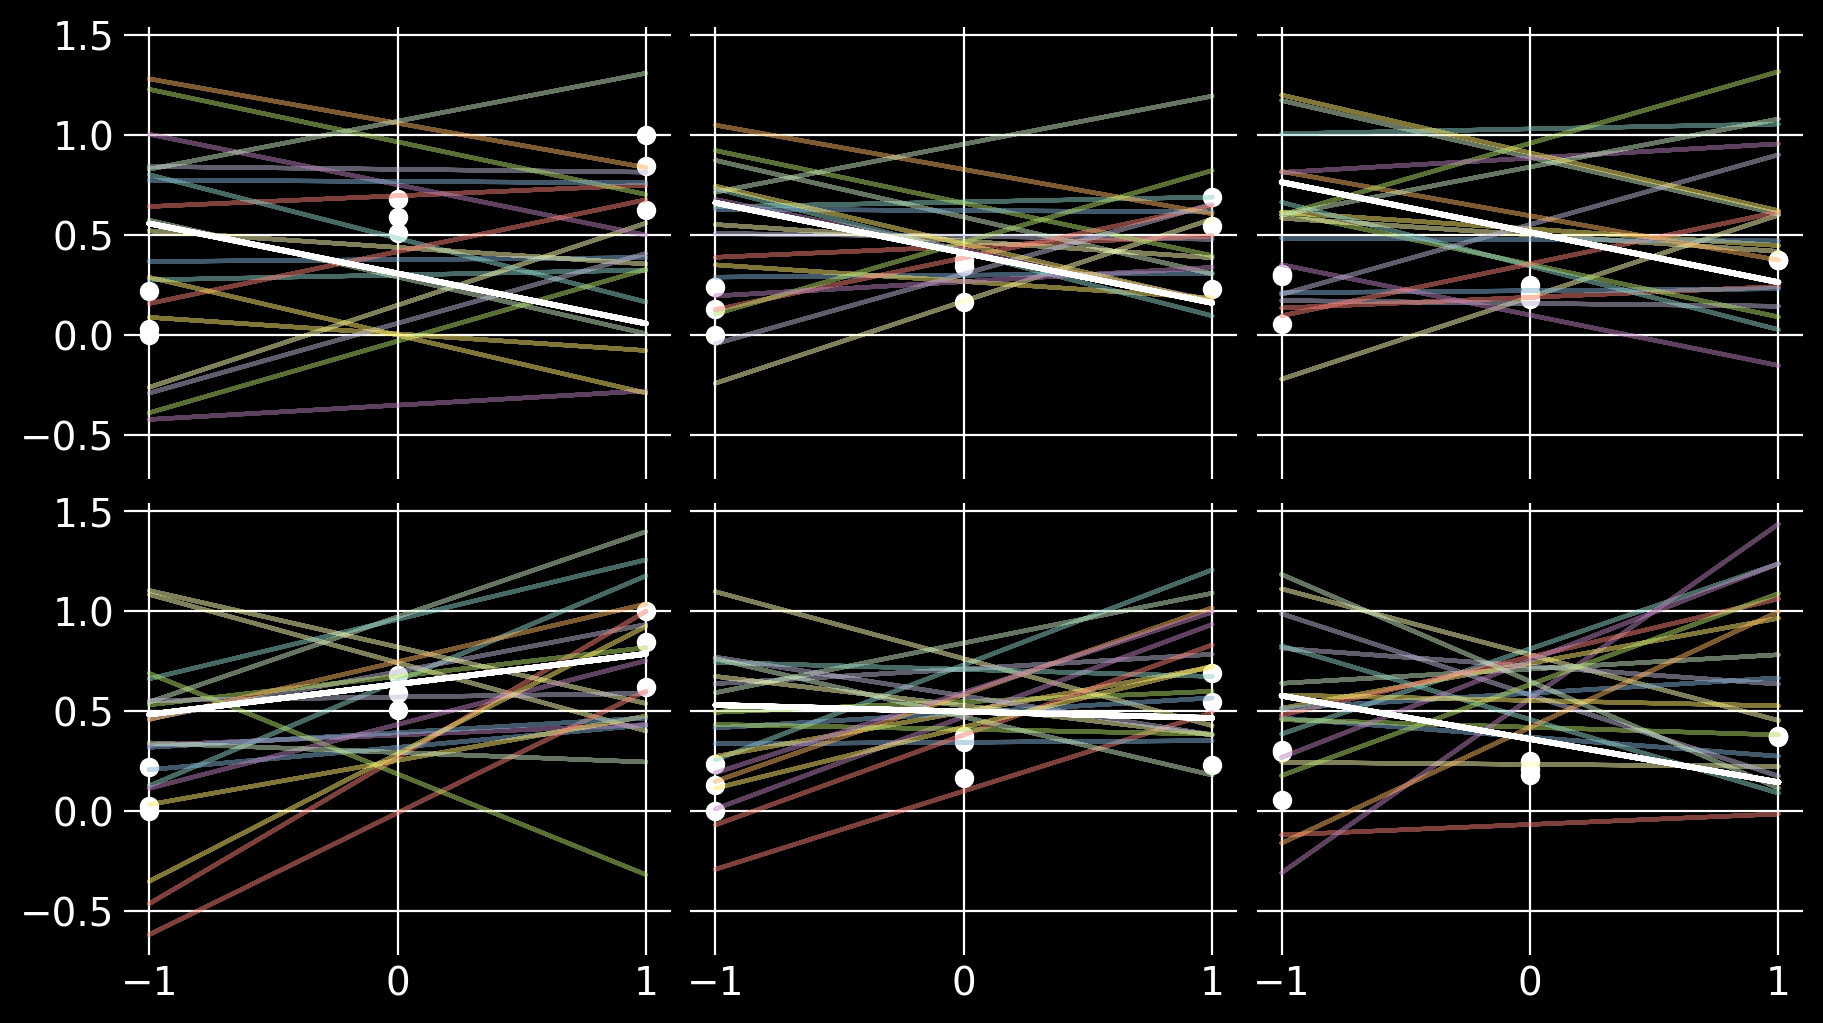

In [460]:
## prior regression lines
##   one example prior parameter set in bold

_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)
n = 20

for i, shade in enumerate([-1, 0, 1]):
    example=5
    idx = d["S"] == shade
    ax = axs[0, i]
    ax.scatter(d[idx]["W"], d[idx]["B"], color="w")
    ax.plot(d[idx]["W"], prior84.prior["mu"][0,0:n,idx].T, alpha=0.5);
    ax.plot(d[idx]["W"], prior84.prior["mu"][0,example,idx].T, color="w", lw=2);

    ax = axs[1, i]
    ax.scatter(d[idx]["W"], d[idx]["B"], color="w")
    ax.plot(d[idx]["W"], prior85.prior["mu"][0,0:n,idx].T, alpha=0.5);
    ax.plot(d[idx]["W"], prior85.prior["mu"][0,example,idx].T, color="w", lw=2);